# 신용대출 심사_feature 값에 따른 예측값 변화량 분석

## 1.환경준비

### 1) 라이브러리 로딩

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.backend import clear_session

### 2) 필요한 함수 생성

In [3]:
# 변수 중요도 plot1
def plot_feature_importance(importance, names, topn = 'all'):

    # 변수중요도, feature 이름 정리
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # 데이터프레임으로 변환
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    # 중요도 순으로 정렬
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    # 전체? or top N?
    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    # 그래프 그리기
    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('importance')
    plt.ylabel('feature names')
    plt.grid()

    # 정리한 변수 중요도 df return
    return fi_df

In [4]:
# 변수 중요도 plot2
def plot_PFI(pfi, col_names):
    plt.figure(figsize = (14,5))
    plt.subplot(1,2,1)
    for i,vars in enumerate(col_names) :
        sns.kdeplot(pfi.importances[i], label = vars)
    plt.legend()
    plt.grid()

    sorted_idx = pfi.importances_mean.argsort()
    plt.subplot(1,2,2)
    plt.boxplot(pfi.importances[sorted_idx].T, vert=False, labels=col_names[sorted_idx])
    plt.axvline(0, color = 'r')
    plt.grid()
    plt.show()

In [5]:
def ice_plot(model, x, y, data_1row, var) :

    # ① x_train에서 crim의 값들을 뽑습니다.
    x_values = x[var].sort_values()

    # ② data1의 crim 에 ①의 값을 하나씩 넣으며 예측값을 계산합니다.
    pred = []

    for v in x_values :
        data_1row[var] = v
        pred.append(model.predict_proba(data_1row)[0][1])

    # ③ 이를 그래프로 그립니다. x축 : crim, y축 : 예측값
    sns.lineplot(x = x_values, y = pred)
    plt.ylim(y.min(), y.max())  # 실제 값의 범위 지정
    plt.grid()
    plt.show()

### 3) 데이터 로딩

In [6]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/credit_all.csv'
data = pd.read_csv(path)
data.loc[data['Payment'] == 4, 'Payment'] = 3
data.drop('Purpose', axis = 1, inplace = True)
data.head()

,Creditability,AccountBalance,Duration,Payment,CreditAmount,Employment,SexMarital,CurrentAddress,MostValuableAsset,Age,Apartment,CreditCount,Occupation,Dependents,Telephone,ForeignWorker
0,1,3,24,2,1249,2,4,2,1,28,2,1,3,1,1,1
1,1,2,9,2,276,3,4,4,1,22,1,1,2,1,1,1
2,1,1,18,3,1049,2,2,4,2,21,1,1,3,1,1,1
3,1,1,24,3,6419,5,2,4,4,44,3,2,4,2,2,1
4,1,3,12,2,1424,5,2,4,1,55,2,1,4,1,2,1


|	칼럼명	|	설명	|	 	|	값 의미	|
|	-----	|	-----	|	-----	|	-----	|
|	Creditability	|	Creditability(Target)	|	향후 신용도	|	0 : Bad, 1 : Good	|
|	AccountBalance	|	Account Balance	|	은행잔고	|	1: No account, 2 : None (No balance), 3 : Some Balance	|
|	CreditDuration	|	Duration of Credit (month)	|	신청한 대출기간(월)	|	숫자	|
|	Payment	|	Payment Status of Previous Credit	|	과거 대출 납입 상태	|	0 : 연체, 1 : 기타신용, 2 : 완납, 3 : 정상 대출상환 중 |
|	Purpose	|	Purpose	|	신청한 대출목적	|	1 : New Car , 2 : Used Car , 3 : Furniture , 4 : TV , 5 : Appliances , 6 : Repair , 8 : Vacation , 9 :Retraining , 10 : Business , 0 : Other	|
|	CreditAmount	|	Credit Amount($)	|	신청한 대출금액	|		|
|	Employment	|	Length of current employment(Month)	|	현 직업 근무 기간	|	1: Unemployed,  2: <1 Year,  3: [1, 4),  4: [4, 7),  5: Above 7	|
|	SexMarital	|	Sex & Marital Status	|	성별 & 결혼상태	|	1: Male, Divorced, 2: Male, Single , 3: Male, Married/Widowed , 4: Female	|
|	CurrentAddress	|	Duration in Current address	|	현 거주지 거주기간	|	1: <1 Year , 2: [1, 4) , 3: [4, 7) , 4: Above 7	|
|	MostValuable	|	Most valuable available asset	|	가장 가치있는 자산	|	1: None , 2: Car , 3: Life Insurance , 4: Real Estate	|
|	Age	|	Age (years)	|	나이	|		|
|	AppartmentType	|	Type of apartment	|	주거환경	|	1: free apartment, 2: Rented, 3: Owned	|
|	NoCredits	|	No of Credits at this Bank	|	현재 총 대출 건수	|	1 : one, 2 : 2 ~ 3, 3 : 4 ~ 5, 4 : 6 ~	|
|	Occupation	|	Occupation	|	직업	|	1: Unemployed, unskilled, 2: Unskilled Permanent Resident, 3: Skilled, 4: Executive	|
|	Telephone	|	Telephone	|	전화기 소유 여부	|	2: Yes , 1: No	|
|	ForeignWorker	|	Foreign Worker	|	외국인 근로자 여부	|	2: Yes , 1: No	|


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Creditability      1000 non-null   int64
 1   AccountBalance     1000 non-null   int64
 2   Duration           1000 non-null   int64
 3   Payment            1000 non-null   int64
 4   CreditAmount       1000 non-null   int64
 5   Employment         1000 non-null   int64
 6   SexMarital         1000 non-null   int64
 7   CurrentAddress     1000 non-null   int64
 8   MostValuableAsset  1000 non-null   int64
 9   Age                1000 non-null   int64
 10  Apartment          1000 non-null   int64
 11  CreditCount        1000 non-null   int64
 12  Occupation         1000 non-null   int64
 13  Dependents         1000 non-null   int64
 14  Telephone          1000 non-null   int64
 15  ForeignWorker      1000 non-null   int64
dtypes: int64(16)
memory usage: 125.1 KB



* 데이터의 크기를 살펴봅시다.

In [7]:
data.shape

(1000, 16)

* Target 변수 조회

1    700
0    300
Name: Creditability, dtype: int64
1    0.7
0    0.3
Name: Creditability, dtype: float64


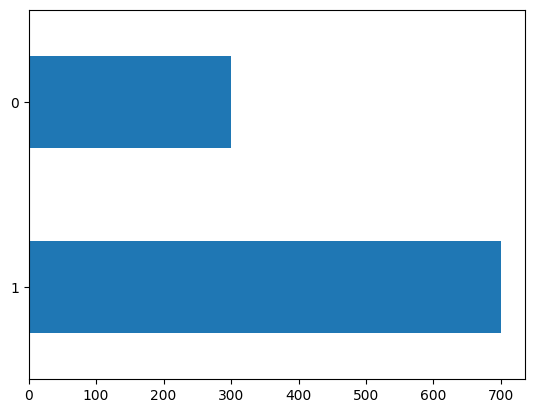

In [8]:
print(data['Creditability'].value_counts())
print(data['Creditability'].value_counts(normalize = True))

data['Creditability'].value_counts().plot(kind = 'barh')
plt.show()

## 2.데이터 준비


### 1) x, y로 나누기

In [9]:
target = 'Creditability'
x = data.drop(target, axis = 1)
y = data.loc[:,target]

### 2) 가변수화

In [10]:
dummy_vars = ['SexMarital', 'MostValuableAsset','ForeignWorker','Telephone']

x = pd.get_dummies(x, columns = dummy_vars, drop_first = True)
x.head()

,AccountBalance,Duration,Payment,CreditAmount,Employment,CurrentAddress,Age,Apartment,CreditCount,Occupation,Dependents,SexMarital_2,SexMarital_3,SexMarital_4,MostValuableAsset_2,MostValuableAsset_3,MostValuableAsset_4,ForeignWorker_2,Telephone_2
0,3,24,2,1249,2,2,28,2,1,3,1,0,0,1,0,0,0,0,0
1,2,9,2,276,3,4,22,1,1,2,1,0,0,1,0,0,0,0,0
2,1,18,3,1049,2,4,21,1,1,3,1,1,0,0,1,0,0,0,0
3,1,24,3,6419,5,4,44,3,2,4,2,1,0,0,0,0,1,0,1
4,3,12,2,1424,5,4,55,2,1,4,1,1,0,0,0,0,0,0,1


### 3) train : validation 분할

In [11]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .2, random_state = 20)

## 3.모델링
* 과제1에서 선정된 모델 로딩

### 1) 모델로딩

In [12]:
import joblib

In [13]:
model = joblib.load('model.pkl')

### 2) 모델사용

In [14]:
pred = model.predict(x_val)

In [15]:
print(confusion_matrix(y_val, pred ))
print(classification_report(y_val, pred ))

[[ 32  39]
 [ 13 116]]
              precision    recall  f1-score   support

           0       0.71      0.45      0.55        71
           1       0.75      0.90      0.82       129

    accuracy                           0.74       200
   macro avg       0.73      0.67      0.68       200
weighted avg       0.74      0.74      0.72       200



### 3) 변수 중요도 확인
* plot_feature_importance 사용

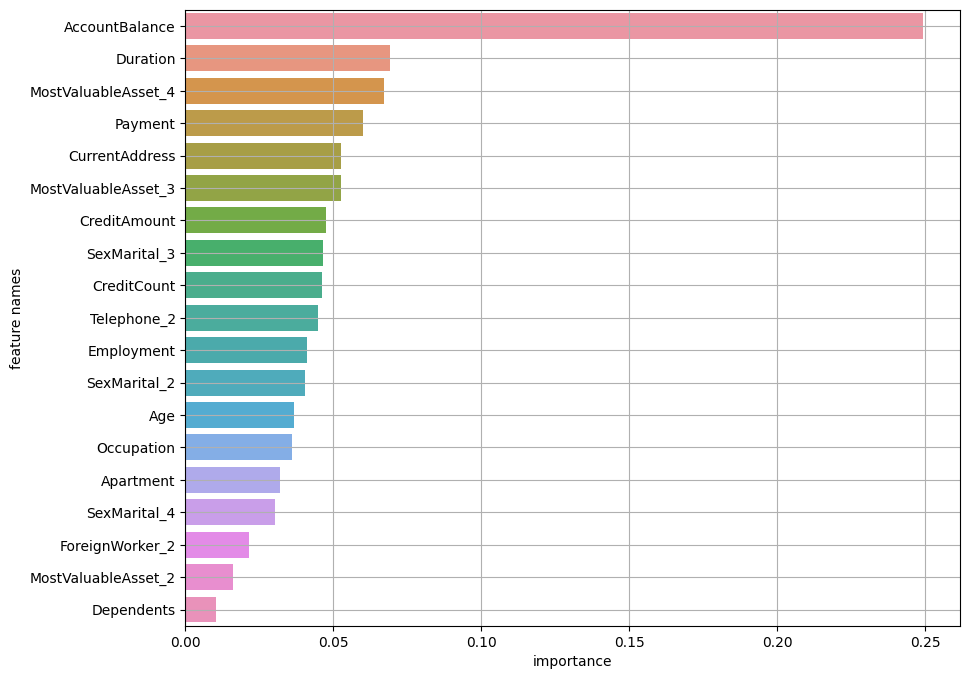

In [16]:
result = plot_feature_importance(model.best_estimator_.feature_importances_, list(x))

## 4.PDP1
* 변수 중요도를 참조하여, 상위 4~5개의 변수를 도출합니다.
* 도출된 변수에 대해서, PDP로 중요 변수의 값에 따라 예측 값 변화를 비교해 봅시다.

In [18]:
from sklearn.inspection import PartialDependenceDisplay, partial_dependence

### 1) feature 1

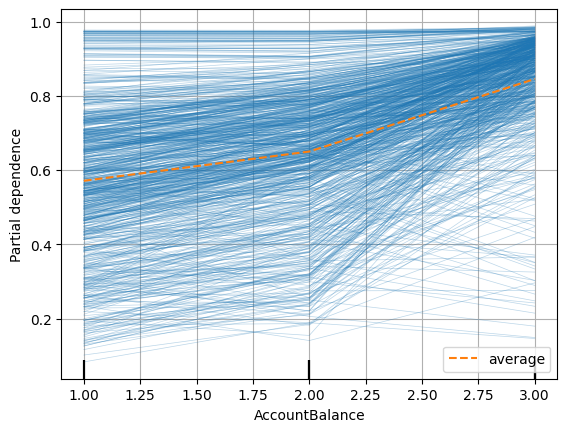

In [19]:
var = 'AccountBalance'
PartialDependenceDisplay.from_estimator(model, x_train, [var], kind="both")
plt.grid()
plt.show()

In [ ]:
# 평균적으로 은행잔고가 많을수록 신용도가 올라간다.
# 잔고가 적어도 신용도가 높은사람들은 가치있는자산이 좋은경우일거같다
# 은행잔고가 많아질수록 신용도가 떨어지는 사람들은 대출연체일이 많은 사람, 직업이없거나 다른자산이 없거나 등등의 이유가 있을거같다.

### 2) feature 2

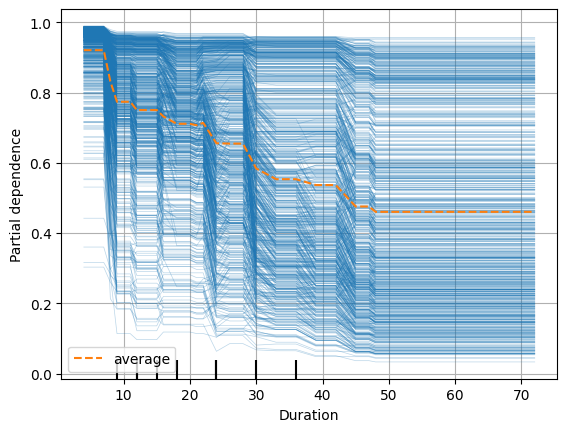

In [20]:
var = 'Duration'
PartialDependenceDisplay.from_estimator(model, x_train, [var], kind="both")
plt.grid()
plt.show()

In [ ]:
# 평균적으로 대출기간이 늘어날수록 신용도가 낮아진다.
# 직업이나 다른 가치자산 등에 따라 대출기간이 늘어나도 신용도가 안떨어지는 사람도 있고, 그 반대로 급격히 떨어지는 사람도 있는거 같다.

### 3) feature 3

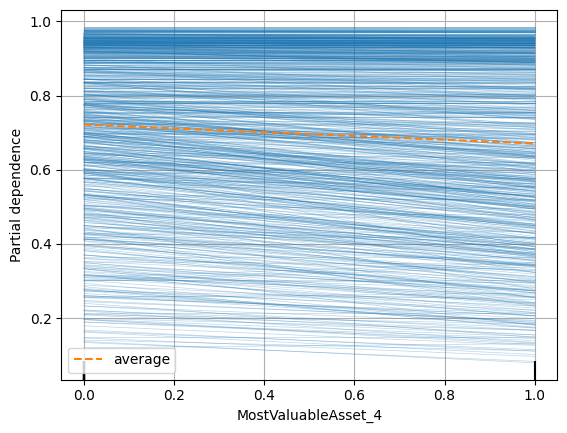

In [21]:
var = 'MostValuableAsset_4'
PartialDependenceDisplay.from_estimator(model, x_train, [var], kind="both")
plt.grid()
plt.show()

### 4) feature 4

### 5) feature 5

## 5.PDP2
* 상위 변수들 중 2개로 구성된 조합 2~3개를 선정합니다.
* 두 변수의 영향력을 비교해 봅시다.
* 두 변수의 조합을 분석해 봅시다.

### 1) 조합1

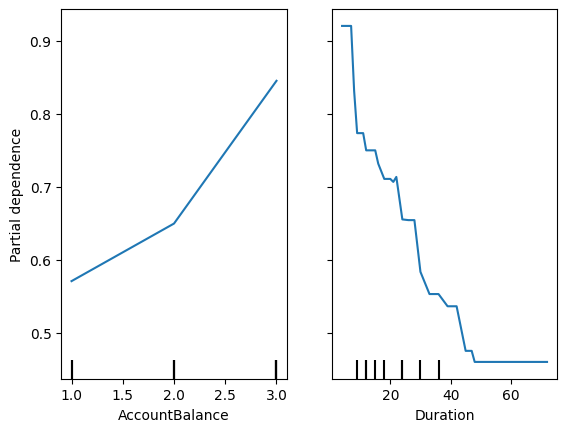

In [23]:
PartialDependenceDisplay.from_estimator(model, x_train, ['AccountBalance','Duration'])
plt.show()

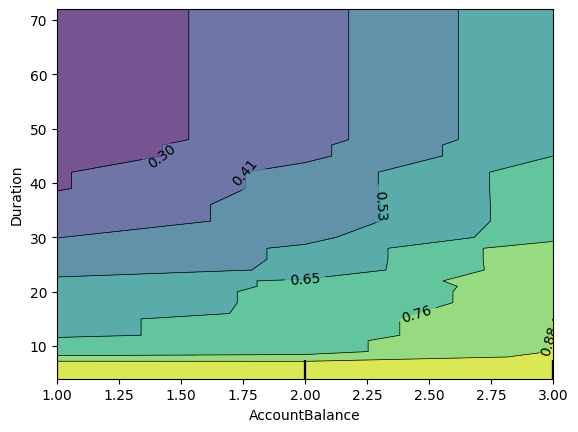

In [24]:
PartialDependenceDisplay.from_estimator(model, x_train, [('AccountBalance','Duration')])
plt.show()

### 2) 조합2

In [ ]:
PartialDependenceDisplay.from_estimator(model, x_train, ['MonthlyIncome','MaritalStatus_Married'])
plt.show()

### 3) 조합3

## 6.특정고객관점(ICE)

* 고객 2~3명을 선정
* 중요 변수의 변화에 따라 예측 값은 어떻게 변화할지 분석해 봅시다.

In [28]:
x_train.head(1)

,AccountBalance,Duration,Payment,CreditAmount,Employment,CurrentAddress,Age,Apartment,CreditCount,Occupation,Dependents,SexMarital_2,SexMarital_3,SexMarital_4,MostValuableAsset_2,MostValuableAsset_3,MostValuableAsset_4,ForeignWorker_2,Telephone_2
504,2,12,2,625,2,1,26,2,1,2,1,0,0,1,0,0,0,0,0


,AccountBalance,Duration,Payment,CreditAmount,Employment,CurrentAddress,Age,Apartment,CreditCount,Occupation,Dependents,SexMarital_2,SexMarital_3,SexMarital_4,MostValuableAsset_2,MostValuableAsset_3,MostValuableAsset_4,ForeignWorker_2,Telephone_2
504,2,12,2,625,2,1,26,2,1,2,1,0,0,1,0,0,0,0,0


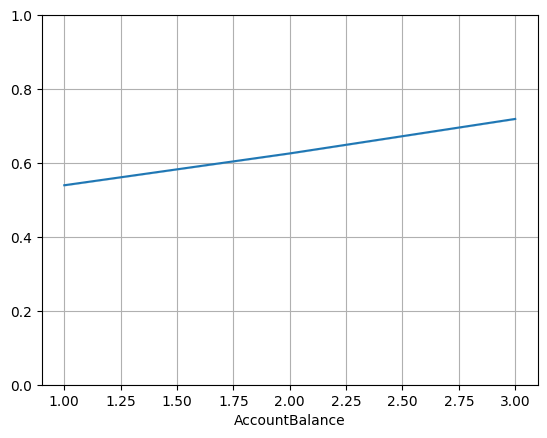

In [26]:
id = 0
var = 'AccountBalance'
data1 = x_train.iloc[[id]]
display(data1)
ice_plot(model, x_train, y_train, data1, var)

,AccountBalance,Duration,Payment,CreditAmount,Employment,CurrentAddress,Age,Apartment,CreditCount,Occupation,Dependents,SexMarital_2,SexMarital_3,SexMarital_4,MostValuableAsset_2,MostValuableAsset_3,MostValuableAsset_4,ForeignWorker_2,Telephone_2
504,2,12,2,625,2,1,26,2,1,2,1,0,0,1,0,0,0,0,0


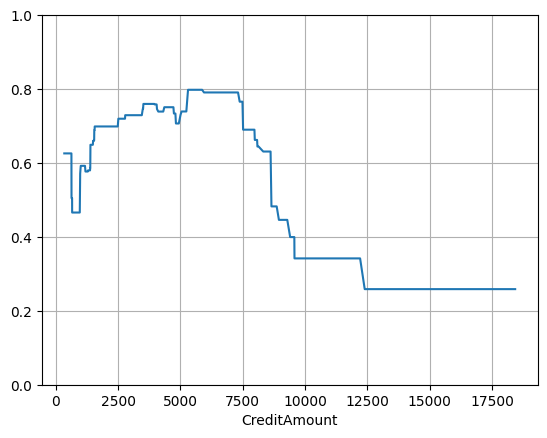

In [29]:
id = 0
var = 'CreditAmount'
data1 = x_train.iloc[[id]]
display(data1)
ice_plot(model, x_train, y_train, data1, var)

,AccountBalance,Duration,Payment,CreditAmount,Employment,CurrentAddress,Age,Apartment,CreditCount,Occupation,Dependents,SexMarital_2,SexMarital_3,SexMarital_4,MostValuableAsset_2,MostValuableAsset_3,MostValuableAsset_4,ForeignWorker_2,Telephone_2
504,2,12,2,625,2,1,26,2,1,2,1,0,0,1,0,0,0,0,0


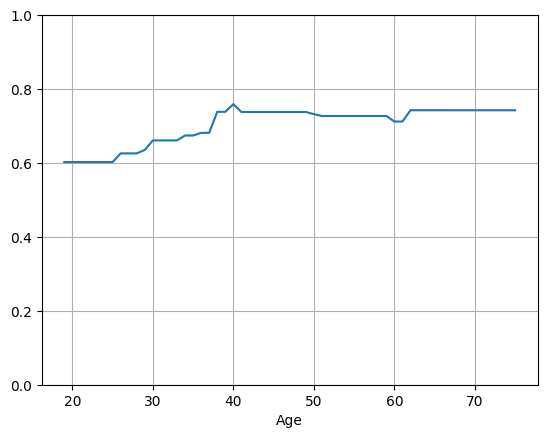

In [36]:
id = 0
var = 'Age'
data1 = x_train.iloc[[id]]
display(data1)
ice_plot(model, x_train, y_train, data1, var)